# Exercise 2. Generate forcing for any region from ERA5 for HBV model

In this exercise you will test you model again, but now based on forcing data which will be generated from ERA5. This notebook will execute the steps to generate forcing from ERA5 for the region you choose. For forcing generation we use the eWaterCycle generic forcing generator. This can generate forcing data with ESMValTool from ERA5 data (if available on your machine, which it is on the Surf Research Cloud that we are using), as well as CMIP6 data (which will be downloaded automatically). CMIP6 data will be discussed in a later notebook.

You need to provide your own shapefile by uploading it to the "Forcing" directory, which you can find in the file browser on the left. For testing purposes, we have already uploaded a shapefile for the Rhine. Save the shapefile with a name indicating the region you chose, like we did for the Rhine.  Ensure that you upload all associated files required for the shapefile to function correctly. The necessary file extensions include ```.dbf```, ```.prj```, ```.qpj```, ```.shp``` and ```.shx```. Without these files, eWaterCycle will not be able to read the shapefile properly.

We have seperated generating the forcing and running the model into two notebooks because generating the forcing is quite heavy on the hardware and we want to minimize the number of times you have to do that. After generating your forcing in this notebook, it will be saved so we can load it later without having to re-run it.


In [1]:
# Required dependencies, note that we do not need to import the model for only generating forcing
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rich import print
import shutil

/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set lisflood_fraser loaded in config but /data/shared/parameter-sets/lisflood_fraser does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set lisflood_fraser loaded in config but /data/shared/parameter-sets/lisflood_fraser/settings_lat_lon-Run.xml does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-packages/pydantic/main.py:214: UserWarning: Parameter set pcrglobwb_rhinemeuse_30min loaded in config but /data/shared/parameter-sets/pcrglobwb_rhinemeuse_30min does not seem to exist.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
/opt/conda/envs/ewatercycle2/lib/python3.12/site-p

Change the variable ```own_region```  to the name of your shapefile in the code cell below. This will be used to import the shapefile and create the forcing. 

In [2]:
# Name of your shapefile/region without extension:
own_region = "HN4326"  # for example: "Rhine"

In [3]:
if own_region == None:  # if nothing is provided, the Rhine shapefile will be used
    own_region = "Rhine"


# Shapefile that describes the basin we want to study.
path = Path.cwd()
forcing_path = path / "Forcing"    
shapeFile = forcing_path / f"{own_region}.shp"

# Location to save forcing results
saveLocation = forcing_path / f"{own_region}Forcing"

In the cell below you can indicate the time period of your interest. Make sure that ERA5 is available on your machine for this period. On our machine ERA5 is available from 1990 up until 2019, (for the course ENVM1502 ERA5 is available from 2010-01-01 until 2014-12-31) so choose a period within this timeframe and make sure you have observation data of discharge available for the same period!

In [4]:
experiment_start_time = "2010-01-01T00:00:00Z"
experiment_end_time = "2014-12-31T00:00:00Z"

Forcing is created using the LumpedMakkinkForcing option in eWaterCycle. This selects rainfall and precipitation from the indicated dataset for the given time period and averages over the indicated shape. It calculates potential evaporation using the approximation by Makkink. The result is two NetCDF files and a yaml file. This can later be loaded using ```ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(forcingLocation)```. Depending on how busy the machine is and how big the area is you are generating forcing for, the cell below can take several minutes to run.

In [5]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
    dataset="ERA5",
    start_time=experiment_start_time,
    end_time=experiment_end_time,
    shape=shapeFile.absolute(),
)


In [6]:
print(f"The forcing object you created: \n {ERA5_forcing}")

The forcing object you created: 
 start_time='2010-01-01T00:00:00Z' end_time='2014-12-31T00:00:00Z' 
directory=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/esmvaltool_output/ewcrep
5vpk17d7_20250413_122223/work/diagnostic/script') 
shape=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing/HN4326.shp') 
filenames={'pr': 'OBS6_ERA5_reanaly_1_day_pr_2010-2014.nc', 'tas': 'OBS6_ERA5_reanaly_1_day_tas_2010-2014.nc', 
'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2010-2014.nc', 'evspsblpot': 'Derived_Makkink_evspsblpot.nc'}

The ERA5 forcing is converted to an xarray. Xarray is a Python package for working with labeled multi-dimensional arrays, it includes functions for advanced analytics and visualization. In this way, it is easier to plot the data.
The forcing (precipitation and the potential evaporation) are plotted in the figure below. 


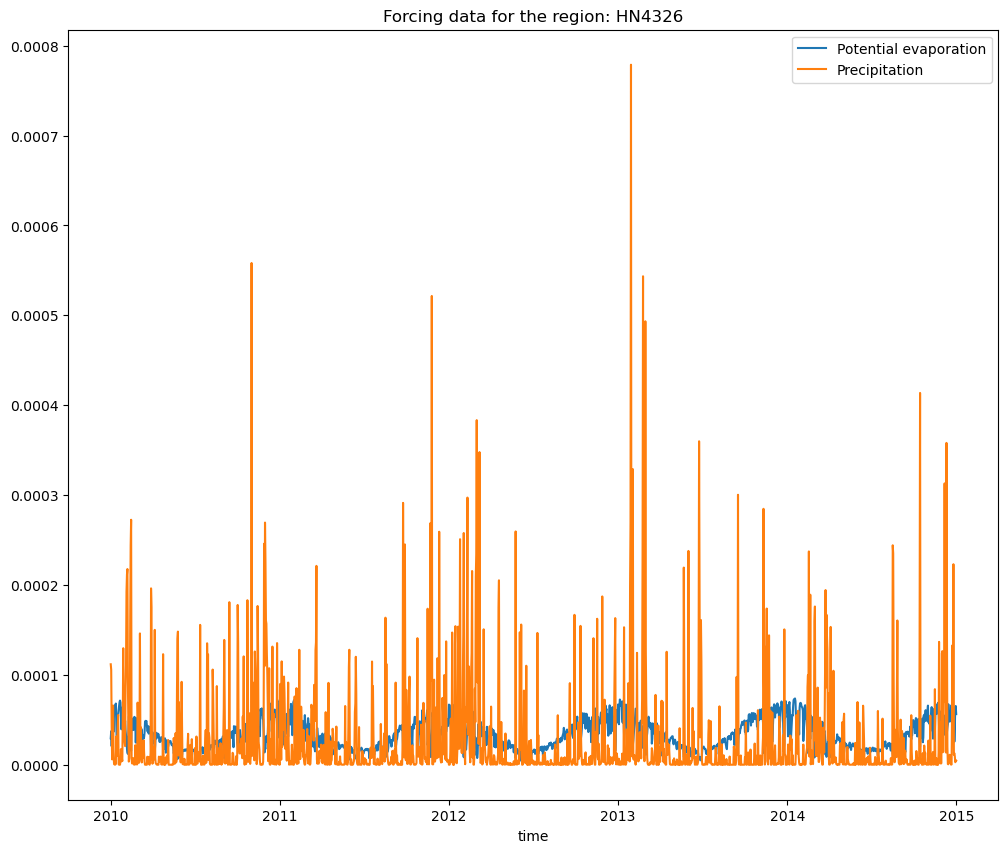

In [7]:
evap = ERA5_forcing.to_xarray()["evspsblpot"]
prec = ERA5_forcing.to_xarray()["pr"]

fig, ax = plt.subplots(figsize=(12,10))

evap.plot(ax=ax, label='Potential evaporation')
prec.plot(ax=ax, label='Precipitation')
ax.set_ylabel('')
ax.set_title(f'Forcing data for the region: {own_region}')
ax.legend()

Finally, the forcing is saved deep in an ESMValTool directory that was just created. For easy loading in other notebooks, let's save it in a better location.

In [8]:
shutil.copytree(ERA5_forcing.directory, saveLocation)

FileExistsError: [Errno 17] File exists: '/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing/HN4326Forcing'